# Monthly Expenses Prediction Model
## Building ML models to predict monthly expenses based on historical data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load data
df = pd.read_csv('../data/budget.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Original dataset: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Original dataset: (6064, 3)
Date range: 2022-07-06 05:57:10+00:00 to 2025-11-29 09:09:48+00:00


,date,category,amount
0,2022-07-06 05:57:10+00:00,Restuarant,5.50
1,2022-07-06 05:57:27+00:00,Market,2.00
2,2022-07-06 05:58:12+00:00,Coffe,30.10
3,2022-07-06 05:58:25+00:00,Market,17.33
4,2022-07-06 05:59:00+00:00,Restuarant,5.50


## 2. Aggregate Data by Month

In [3]:
# Create year-month column
df['year_month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Aggregate monthly data
monthly_data = df.groupby('year_month').agg({
    'amount': ['sum', 'mean', 'std', 'count', 'min', 'max']
}).reset_index()

monthly_data.columns = ['year_month', 'total_amount', 'avg_amount', 'std_amount', 
                        'transaction_count', 'min_amount', 'max_amount']

# Extract year and month
monthly_data['year'] = monthly_data['year_month'].dt.year
monthly_data['month'] = monthly_data['year_month'].dt.month

# Convert year_month to timestamp for easier manipulation
monthly_data['date'] = monthly_data['year_month'].dt.to_timestamp()

print(f"\nMonthly aggregated data: {monthly_data.shape}")
monthly_data.head(10)


Monthly aggregated data: (41, 10)


,year_month,total_amount,avg_amount,std_amount,transaction_count,min_amount,max_amount,year,month,date
0,2022-07,2861.38,34.894878,112.964193,82,1.00,733.25,2022,7,2022-07-01
1,2022-08,1307.52,10.544516,24.345610,124,0.42,220.00,2022,8,2022-08-01
2,2022-09,1338.48,10.296000,21.873854,130,0.60,200.00,2022,9,2022-09-01
3,2022-10,2001.12,11.911429,21.718710,168,0.60,153.00,2022,10,2022-10-01
4,2022-11,1017.81,6.971301,6.104828,146,0.60,50.00,2022,11,2022-11-01
5,2022-12,1605.53,10.996781,22.050566,146,0.50,200.00,2022,12,2022-12-01
6,2023-01,2162.19,11.945801,36.373190,181,0.50,441.00,2023,1,2023-01-01
7,2023-02,1540.84,11.413630,21.232355,135,0.44,181.00,2023,2,2023-02-01
8,2023-03,2274.61,15.579521,29.250880,146,0.70,210.00,2023,3,2023-03-01
9,2023-04,2224.88,21.393077,39.783236,104,0.30,300.00,2023,4,2023-04-01


## 3. Create Category-based Features

In [4]:
# Get spending by category for each month
category_monthly = df.groupby(['year_month', 'category'])['amount'].sum().reset_index()
category_pivot = category_monthly.pivot(index='year_month', columns='category', values='amount').fillna(0)

# Add 'cat_' prefix to category columns
category_pivot.columns = ['cat_' + col for col in category_pivot.columns]
category_pivot = category_pivot.reset_index()

# Merge with monthly data
monthly_data = monthly_data.merge(category_pivot, on='year_month', how='left')

print(f"\nData with category features: {monthly_data.shape}")
print(f"Category columns: {[col for col in monthly_data.columns if col.startswith('cat_')]}")


Data with category features: (41, 33)
Category columns: ['cat_Barber', 'cat_Business lunch', 'cat_Clothing', 'cat_Coffe', 'cat_Communal', 'cat_Events', 'cat_Film/enjoyment', 'cat_Fuel', 'cat_Health', 'cat_Learning', 'cat_Market', 'cat_Motel', 'cat_Other', 'cat_Phone', 'cat_Rent Car', 'cat_Restuarant', 'cat_Sport', 'cat_Taxi', 'cat_Tech', 'cat_Transport', 'cat_Travel', 'cat_business_expenses', 'cat_joy']


## 4. Feature Engineering

In [5]:
# Sort by date to ensure proper time series
monthly_data = monthly_data.sort_values('date').reset_index(drop=True)

# Time-based features
monthly_data['month_sin'] = np.sin(2 * np.pi * monthly_data['month'] / 12)
monthly_data['month_cos'] = np.cos(2 * np.pi * monthly_data['month'] / 12)
monthly_data['quarter'] = monthly_data['month'].apply(lambda x: (x-1)//3 + 1)
monthly_data['is_year_start'] = (monthly_data['month'] == 1).astype(int)
monthly_data['is_year_end'] = (monthly_data['month'] == 12).astype(int)
monthly_data['is_mid_year'] = (monthly_data['month'].isin([6, 7])).astype(int)

# Lag features (previous months' spending)
for lag in [1, 2, 3, 6, 12]:
    monthly_data[f'total_amount_lag_{lag}'] = monthly_data['total_amount'].shift(lag)
    monthly_data[f'transaction_count_lag_{lag}'] = monthly_data['transaction_count'].shift(lag)

# Rolling statistics
for window in [3, 6, 12]:
    monthly_data[f'rolling_mean_{window}'] = monthly_data['total_amount'].rolling(window=window, min_periods=1).mean()
    monthly_data[f'rolling_std_{window}'] = monthly_data['total_amount'].rolling(window=window, min_periods=1).std().fillna(0)
    monthly_data[f'rolling_max_{window}'] = monthly_data['total_amount'].rolling(window=window, min_periods=1).max()
    monthly_data[f'rolling_min_{window}'] = monthly_data['total_amount'].rolling(window=window, min_periods=1).min()

# Exponential weighted moving average
monthly_data['ewm_3'] = monthly_data['total_amount'].ewm(span=3, adjust=False).mean()
monthly_data['ewm_6'] = monthly_data['total_amount'].ewm(span=6, adjust=False).mean()

# Month-over-month change
monthly_data['mom_change'] = monthly_data['total_amount'].pct_change().fillna(0)
monthly_data['mom_change_abs'] = monthly_data['total_amount'].diff().fillna(0)

# Year-over-year growth (if available)
monthly_data['yoy_growth'] = monthly_data['total_amount'].pct_change(periods=12).fillna(0)

# Trend feature (simple linear time index)
monthly_data['time_index'] = range(len(monthly_data))

print(f"\nData after feature engineering: {monthly_data.shape}")
print(f"Total features: {monthly_data.shape[1]}")

# Fill any remaining NaN values with 0
monthly_data = monthly_data.fillna(0)

monthly_data.head()


Data after feature engineering: (41, 67)
Total features: 67


,year_month,total_amount,avg_amount,std_amount,transaction_count,min_amount,max_amount,year,month,date,...,rolling_mean_12,rolling_std_12,rolling_max_12,rolling_min_12,ewm_3,ewm_6,mom_change,mom_change_abs,yoy_growth,time_index
0,2022-07,2861.38,34.894878,112.964193,82,1.00,733.25,2022,7,2022-07-01,...,2861.380000,0.000000,2861.38,2861.38,2861.38000,2861.380000,0.000000,0.00,0.0,0
1,2022-08,1307.52,10.544516,24.345610,124,0.42,220.00,2022,8,2022-08-01,...,2084.450000,1098.744943,2861.38,1307.52,2084.45000,2417.420000,-0.543046,-1553.86,0.0,1
2,2022-09,1338.48,10.296000,21.873854,130,0.60,200.00,2022,9,2022-09-01,...,1835.793333,888.318996,2861.38,1307.52,1711.46500,2109.151429,0.023678,30.96,0.0,2
3,2022-10,2001.12,11.911429,21.718710,168,0.60,153.00,2022,10,2022-10-01,...,1877.125000,730.004785,2861.38,1307.52,1856.29250,2078.285306,0.495069,662.64,0.0,3
4,2022-11,1017.81,6.971301,6.104828,146,0.60,50.00,2022,11,2022-11-01,...,1705.262000,739.840992,2861.38,1017.81,1437.05125,1775.292362,-0.491380,-983.31,0.0,4


In [6]:
# Display all features
print("All features:")
for i, col in enumerate(monthly_data.columns, 1):
    print(f"{i:3d}. {col}")

All features:
  1. year_month
  2. total_amount
  3. avg_amount
  4. std_amount
  5. transaction_count
  6. min_amount
  7. max_amount
  8. year
  9. month
 10. date
 11. cat_Barber
 12. cat_Business lunch
 13. cat_Clothing
 14. cat_Coffe
 15. cat_Communal
 16. cat_Events
 17. cat_Film/enjoyment
 18. cat_Fuel
 19. cat_Health
 20. cat_Learning
 21. cat_Market
 22. cat_Motel
 23. cat_Other
 24. cat_Phone
 25. cat_Rent Car
 26. cat_Restuarant
 27. cat_Sport
 28. cat_Taxi
 29. cat_Tech
 30. cat_Transport
 31. cat_Travel
 32. cat_business_expenses
 33. cat_joy
 34. month_sin
 35. month_cos
 36. quarter
 37. is_year_start
 38. is_year_end
 39. is_mid_year
 40. total_amount_lag_1
 41. transaction_count_lag_1
 42. total_amount_lag_2
 43. transaction_count_lag_2
 44. total_amount_lag_3
 45. transaction_count_lag_3
 46. total_amount_lag_6
 47. transaction_count_lag_6
 48. total_amount_lag_12
 49. transaction_count_lag_12
 50. rolling_mean_3
 51. rolling_std_3
 52. rolling_max_3
 53. rolling_min_

## 5. Prepare Training Data

In [7]:
# Define features to exclude from training
exclude_cols = ['year_month', 'total_amount', 'date', 'year_month']
feature_cols = [col for col in monthly_data.columns if col not in exclude_cols]

# Features and target
X = monthly_data[feature_cols]
y = monthly_data['total_amount']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {len(feature_cols)}")
print(f"\nFeature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:3d}. {col}")

Features shape: (41, 64)
Target shape: (41,)

Number of features: 64

Feature columns (64):
  1. avg_amount
  2. std_amount
  3. transaction_count
  4. min_amount
  5. max_amount
  6. year
  7. month
  8. cat_Barber
  9. cat_Business lunch
 10. cat_Clothing
 11. cat_Coffe
 12. cat_Communal
 13. cat_Events
 14. cat_Film/enjoyment
 15. cat_Fuel
 16. cat_Health
 17. cat_Learning
 18. cat_Market
 19. cat_Motel
 20. cat_Other
 21. cat_Phone
 22. cat_Rent Car
 23. cat_Restuarant
 24. cat_Sport
 25. cat_Taxi
 26. cat_Tech
 27. cat_Transport
 28. cat_Travel
 29. cat_business_expenses
 30. cat_joy
 31. month_sin
 32. month_cos
 33. quarter
 34. is_year_start
 35. is_year_end
 36. is_mid_year
 37. total_amount_lag_1
 38. transaction_count_lag_1
 39. total_amount_lag_2
 40. transaction_count_lag_2
 41. total_amount_lag_3
 42. transaction_count_lag_3
 43. total_amount_lag_6
 44. transaction_count_lag_6
 45. total_amount_lag_12
 46. transaction_count_lag_12
 47. rolling_mean_3
 48. rolling_std_3
 4

In [8]:
# Split data: Use time-based split (last 20% for testing)
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining period: {monthly_data['year_month'].iloc[0]} to {monthly_data['year_month'].iloc[split_idx-1]}")
print(f"Test period: {monthly_data['year_month'].iloc[split_idx]} to {monthly_data['year_month'].iloc[-1]}")

Training set: (32, 64)
Test set: (9, 64)

Training period: 2022-07 to 2025-02
Test period: 2025-03 to 2025-11


In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


## 6. Train Multiple Models

In [10]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=10),
    'ElasticNet': ElasticNet(alpha=10, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

print(f"Training {len(models)} models...\n")

Training 8 models...



In [11]:
# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for linear models, original for tree-based
    if name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"  Train - MAE: ₼{train_mae:.2f}, RMSE: ₼{train_rmse:.2f}, R2: {train_r2:.4f}")
    print(f"  Test  - MAE: ₼{test_mae:.2f}, RMSE: ₼{test_rmse:.2f}, R2: {test_r2:.4f}")
    print()

print("All models trained!")

Training Linear Regression...
  Train - MAE: ₼0.00, RMSE: ₼0.00, R2: 1.0000
  Test  - MAE: ₼209.85, RMSE: ₼239.78, R2: 0.9161

Training Ridge...
  Train - MAE: ₼53.49, RMSE: ₼69.96, R2: 0.9959
  Test  - MAE: ₼229.05, RMSE: ₼276.29, R2: 0.8886

Training Lasso...
  Train - MAE: ₼40.90, RMSE: ₼52.40, R2: 0.9977
  Test  - MAE: ₼190.15, RMSE: ₼230.19, R2: 0.9227

Training ElasticNet...
  Train - MAE: ₼327.38, RMSE: ₼419.98, R2: 0.8518
  Test  - MAE: ₼368.51, RMSE: ₼418.21, R2: 0.7448

Training Random Forest...
  Train - MAE: ₼116.47, RMSE: ₼158.26, R2: 0.9790
  Test  - MAE: ₼330.48, RMSE: ₼451.13, R2: 0.7031

Training Gradient Boosting...


  Train - MAE: ₼0.02, RMSE: ₼0.03, R2: 1.0000
  Test  - MAE: ₼762.97, RMSE: ₼1102.61, R2: -0.7738

Training XGBoost...


  Train - MAE: ₼1.27, RMSE: ₼3.24, R2: 1.0000
  Test  - MAE: ₼430.68, RMSE: ₼626.36, R2: 0.4276

Training LightGBM...


  Train - MAE: ₼794.13, RMSE: ₼1090.87, R2: -0.0000
  Test  - MAE: ₼775.17, RMSE: ₼1030.66, R2: -0.5499

All models trained!


## 7. Compare Models

In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Train RMSE': [results[m]['train_rmse'] for m in results],
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Train R2': [results[m]['train_r2'] for m in results],
    'Test R2': [results[m]['test_r2'] for m in results]
})

# Sort by Test MAE (lower is better)
comparison_df = comparison_df.sort_values('Test MAE')

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
comparison_df


MODEL COMPARISON


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
2,Lasso,4.090452e+01,190.147964,5.240395e+01,230.187269,9.976923e-01,0.922692
0,Linear Regression,1.449507e-12,209.851817,1.792146e-12,239.782504,1.000000e+00,0.916112
1,Ridge,5.348567e+01,229.052645,6.995908e+01,276.286952,9.958871e-01,0.888626
4,Random Forest,1.164699e+02,330.481389,1.582587e+02,451.128333,9.789529e-01,0.703063
3,ElasticNet,3.273760e+02,368.505740,4.199790e+02,418.214730,8.517781e-01,0.744811
6,XGBoost,1.265777e+00,430.676355,3.238983e+00,626.362787,9.999912e-01,0.427579
5,Gradient Boosting,2.212406e-02,762.973548,3.005982e-02,1102.607412,1.000000e+00,-0.773803
7,LightGBM,7.941304e+02,775.171502,1.090866e+03,1030.659170,-2.220446e-16,-0.549864


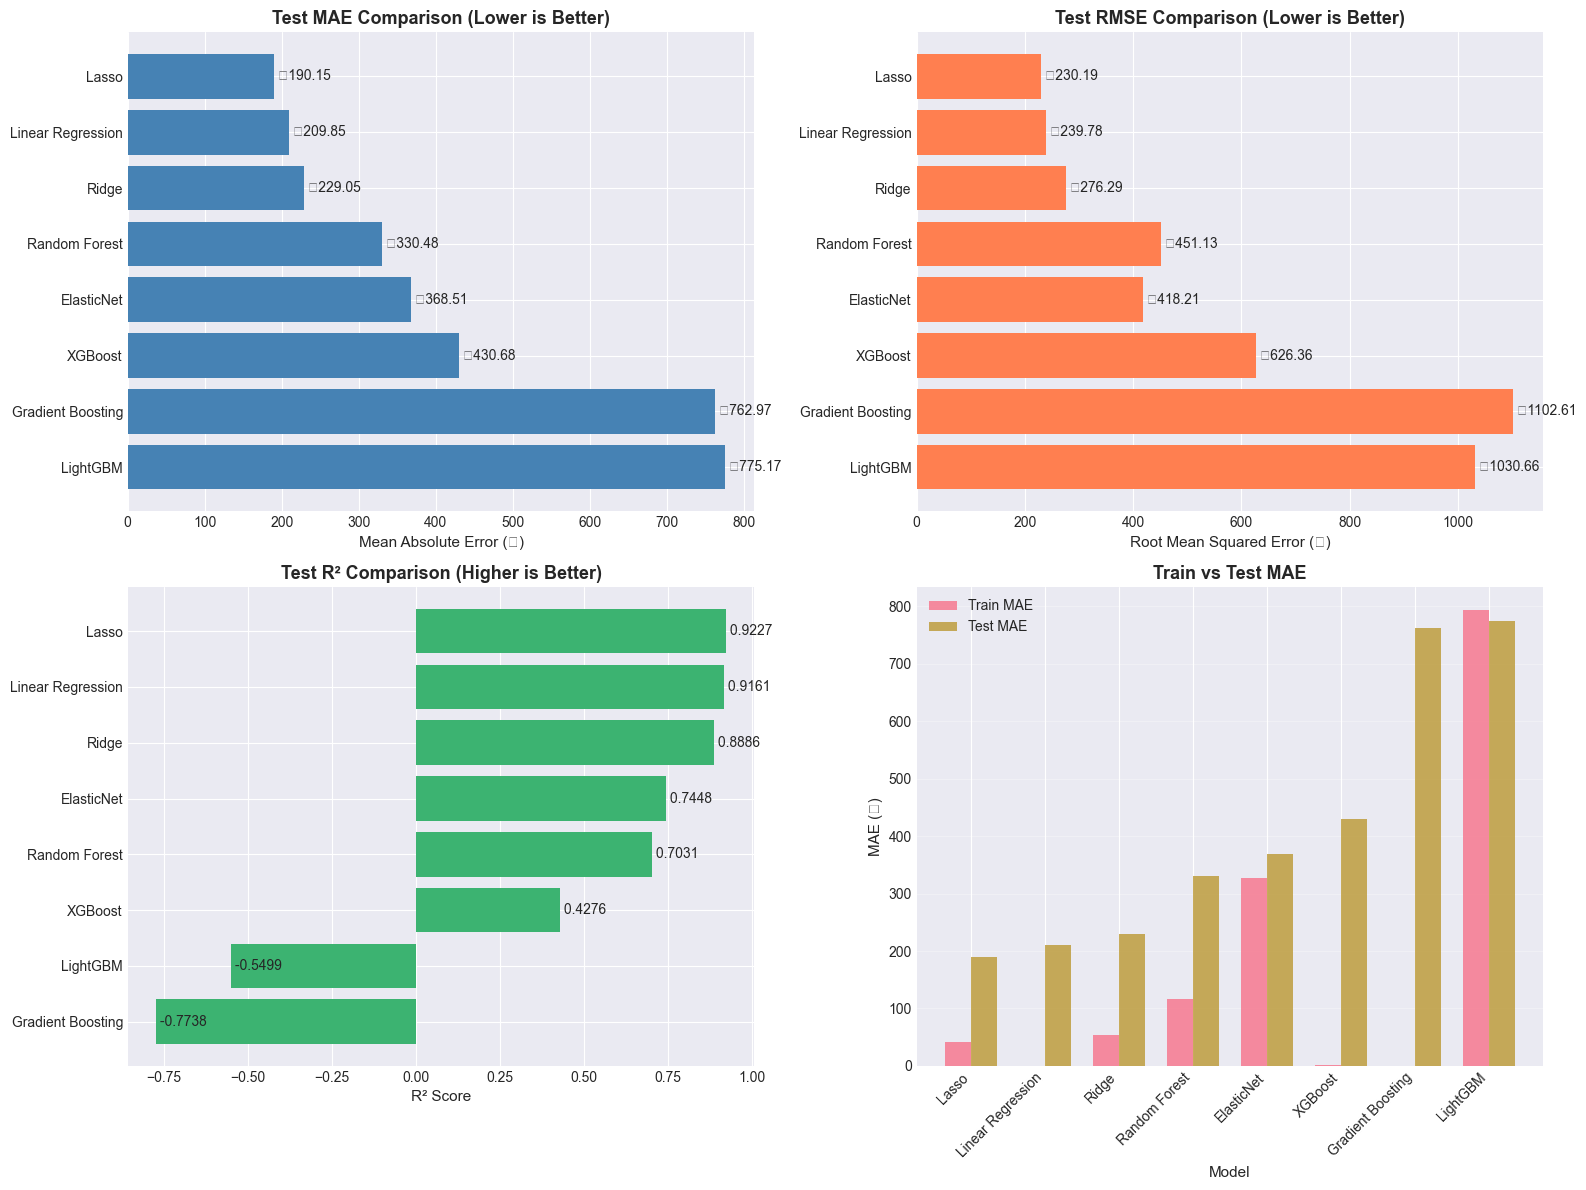

In [13]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test MAE
axes[0, 0].barh(comparison_df['Model'], comparison_df['Test MAE'], color='steelblue')
axes[0, 0].set_xlabel('Mean Absolute Error (₼)', fontsize=11)
axes[0, 0].set_title('Test MAE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
for i, v in enumerate(comparison_df['Test MAE']):
    axes[0, 0].text(v, i, f' ₼{v:.2f}', va='center')

# Test RMSE
axes[0, 1].barh(comparison_df['Model'], comparison_df['Test RMSE'], color='coral')
axes[0, 1].set_xlabel('Root Mean Squared Error (₼)', fontsize=11)
axes[0, 1].set_title('Test RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
for i, v in enumerate(comparison_df['Test RMSE']):
    axes[0, 1].text(v, i, f' ₼{v:.2f}', va='center')

# Test R2
comparison_df_r2 = comparison_df.sort_values('Test R2', ascending=False)
axes[1, 0].barh(comparison_df_r2['Model'], comparison_df_r2['Test R2'], color='mediumseagreen')
axes[1, 0].set_xlabel('R² Score', fontsize=11)
axes[1, 0].set_title('Test R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
for i, v in enumerate(comparison_df_r2['Test R2']):
    axes[1, 0].text(v, i, f' {v:.4f}', va='center')

# Train vs Test MAE comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 1].bar(x - width/2, comparison_df['Train MAE'], width, label='Train MAE', alpha=0.8)
axes[1, 1].bar(x + width/2, comparison_df['Test MAE'], width, label='Test MAE', alpha=0.8)
axes[1, 1].set_xlabel('Model', fontsize=11)
axes[1, 1].set_ylabel('MAE (₼)', fontsize=11)
axes[1, 1].set_title('Train vs Test MAE', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Select best model based on Test MAE
best_model_name = comparison_df.iloc[0]['Model']
best_model_info = results[best_model_name]
best_model = best_model_info['model']

print("="*100)
print(f"BEST MODEL: {best_model_name}")
print("="*100)
print(f"Test MAE:  ₼{best_model_info['test_mae']:.2f}")
print(f"Test RMSE: ₼{best_model_info['test_rmse']:.2f}")
print(f"Test R²:   {best_model_info['test_r2']:.4f}")
print("="*100)

BEST MODEL: Lasso
Test MAE:  ₼190.15
Test RMSE: ₼230.19
Test R²:   0.9227


## 8. Visualize Best Model Performance

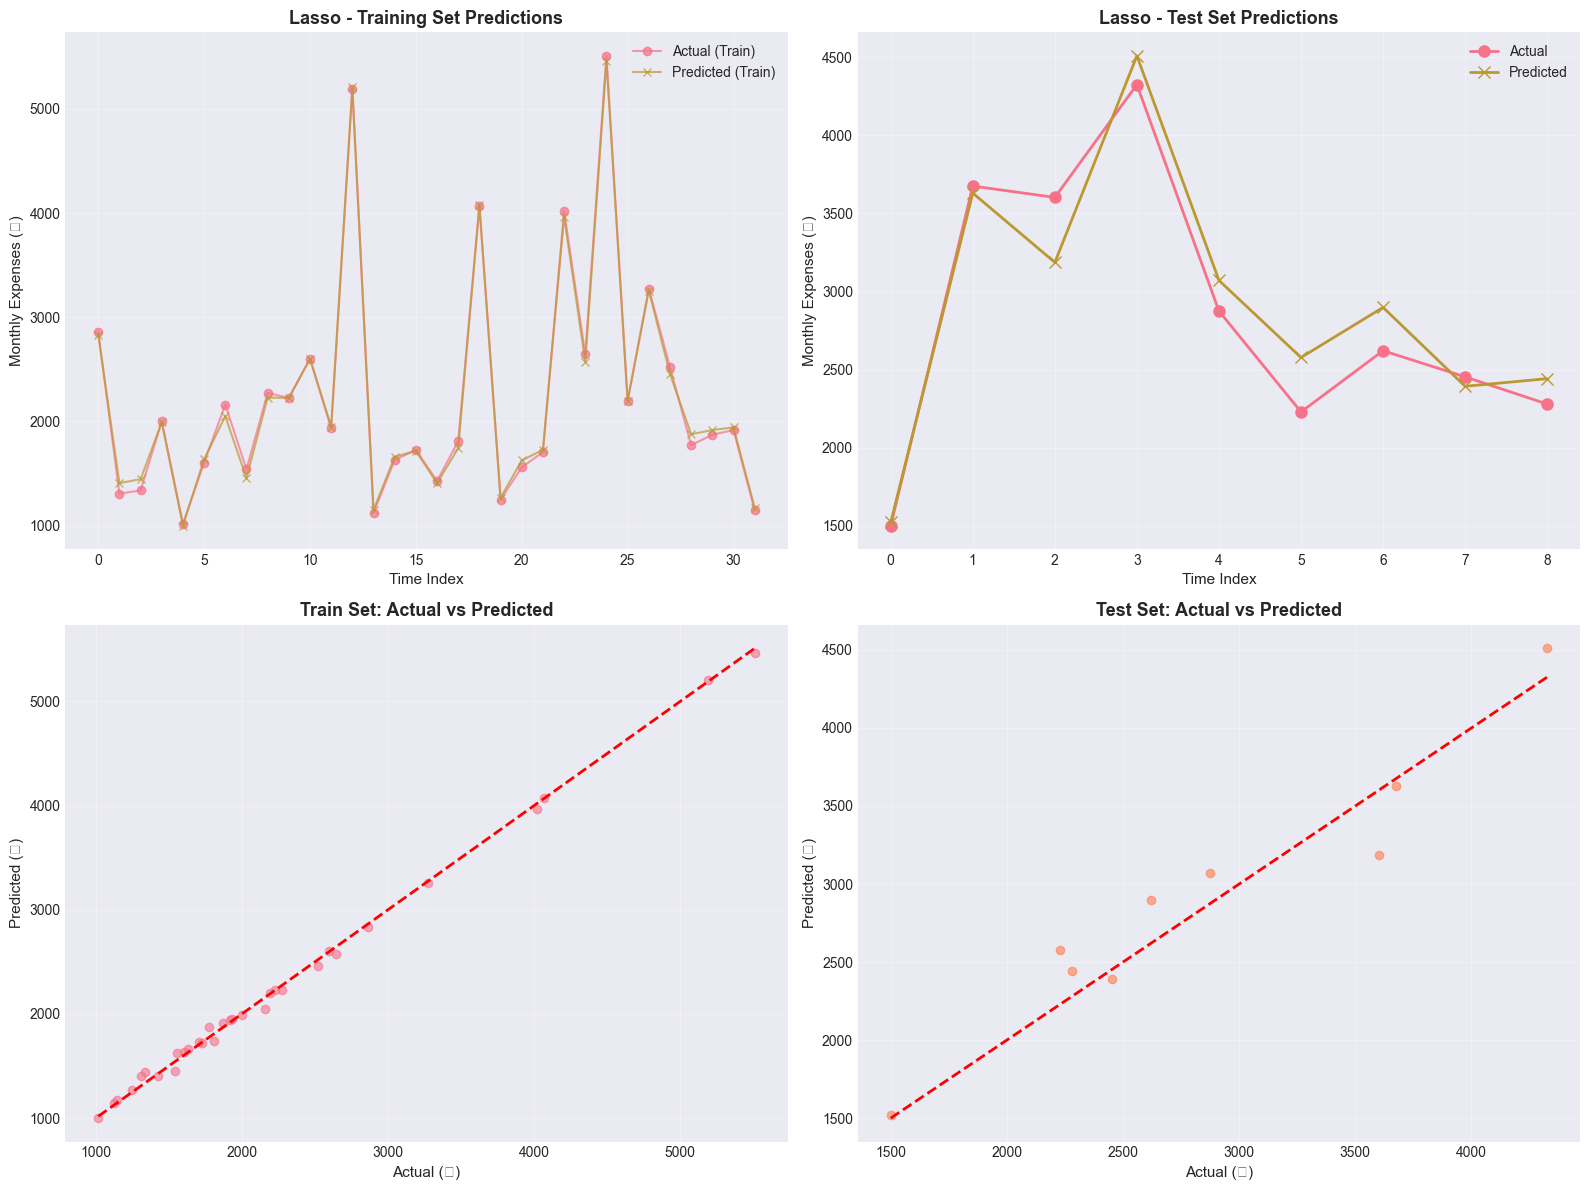

In [15]:
# Get predictions for best model
if best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
    y_pred_train_best = best_model.predict(X_train_scaled)
    y_pred_test_best = best_model.predict(X_test_scaled)
else:
    y_pred_train_best = best_model.predict(X_train)
    y_pred_test_best = best_model.predict(X_test)

# Plot actual vs predicted
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time series plot
axes[0, 0].plot(range(len(y_train)), y_train.values, label='Actual (Train)', marker='o', alpha=0.7)
axes[0, 0].plot(range(len(y_train)), y_pred_train_best, label='Predicted (Train)', marker='x', alpha=0.7)
axes[0, 0].set_xlabel('Time Index', fontsize=11)
axes[0, 0].set_ylabel('Monthly Expenses (₼)', fontsize=11)
axes[0, 0].set_title(f'{best_model_name} - Training Set Predictions', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test set predictions
test_dates = monthly_data['year_month'].iloc[split_idx:].astype(str)
axes[0, 1].plot(range(len(y_test)), y_test.values, label='Actual', marker='o', linewidth=2, markersize=8)
axes[0, 1].plot(range(len(y_test)), y_pred_test_best, label='Predicted', marker='x', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Time Index', fontsize=11)
axes[0, 1].set_ylabel('Monthly Expenses (₼)', fontsize=11)
axes[0, 1].set_title(f'{best_model_name} - Test Set Predictions', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot - Train
axes[1, 0].scatter(y_train, y_pred_train_best, alpha=0.6)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual (₼)', fontsize=11)
axes[1, 0].set_ylabel('Predicted (₼)', fontsize=11)
axes[1, 0].set_title('Train Set: Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot - Test
axes[1, 1].scatter(y_test, y_pred_test_best, alpha=0.6, color='coral')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual (₼)', fontsize=11)
axes[1, 1].set_ylabel('Predicted (₼)', fontsize=11)
axes[1, 1].set_title('Test Set: Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

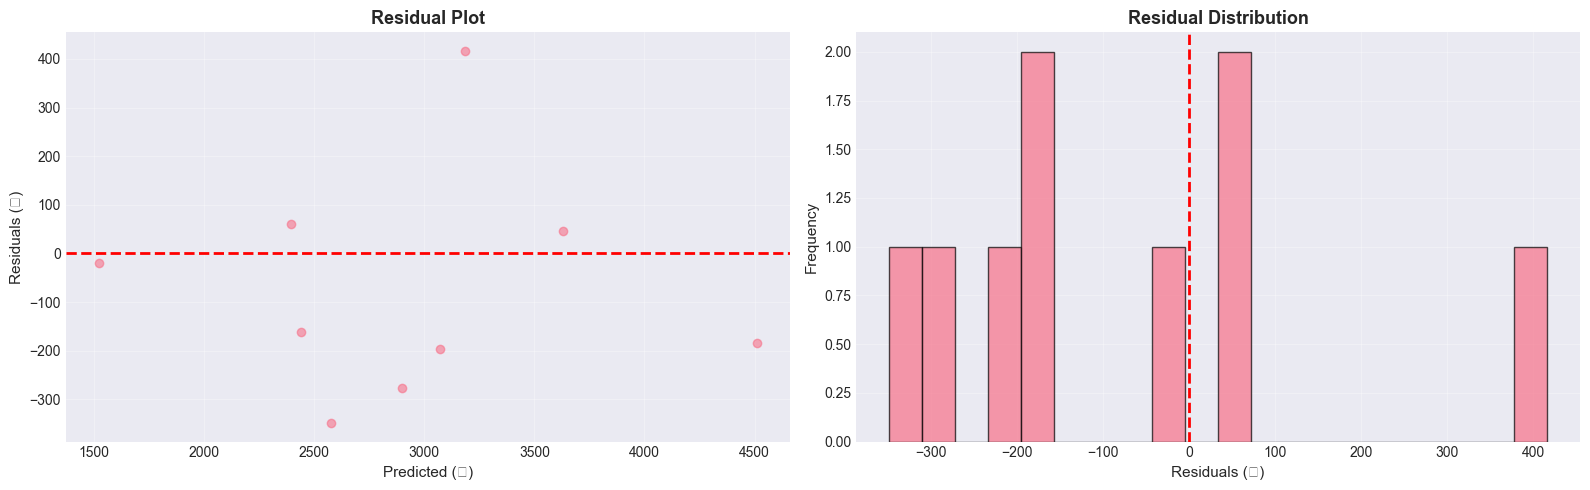

Mean Residual: ₼-74.15
Std Residual: ₼231.14


In [16]:
# Residual analysis
residuals_test = y_test - y_pred_test_best

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Residual plot
axes[0].scatter(y_pred_test_best, residuals_test, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted (₼)', fontsize=11)
axes[0].set_ylabel('Residuals (₼)', fontsize=11)
axes[0].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals_test, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (₼)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: ₼{residuals_test.mean():.2f}")
print(f"Std Residual: ₼{residuals_test.std():.2f}")

## 9. Feature Importance (for tree-based models)

In [17]:
# Feature importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    top_n = min(20, len(feature_importance))
    top_features = feature_importance.head(top_n)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), top_features['importance'])
    plt.yticks(range(top_n), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 20 Important Features:")
    print(feature_importance.head(20))
else:
    print(f"{best_model_name} does not provide feature importance.")

Lasso does not provide feature importance.


## 10. Save Model and Artifacts for Deployment

In [18]:
# Create model artifacts dictionary
model_artifacts = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'feature_columns': feature_cols,
    'use_scaled': best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet'],
    'metrics': {
        'test_mae': best_model_info['test_mae'],
        'test_rmse': best_model_info['test_rmse'],
        'test_r2': best_model_info['test_r2']
    },
    'training_data': monthly_data,  # Save for feature engineering
    'all_category_columns': [col for col in monthly_data.columns if col.startswith('cat_')]
}

# Save individual artifacts
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(feature_cols, '../models/feature_columns.pkl')
joblib.dump(model_artifacts, '../models/model_artifacts.pkl')

# Save monthly data for future predictions
monthly_data.to_csv('../models/training_monthly_data.csv', index=False)

print("="*100)
print("MODEL ARTIFACTS SAVED TO ../models/")
print("="*100)
print("Saved files:")
print("  1. best_model.pkl - The trained model")
print("  2. scaler.pkl - Feature scaler")
print("  3. feature_columns.pkl - List of feature columns")
print("  4. model_artifacts.pkl - Complete artifacts including metadata")
print("  5. training_monthly_data.csv - Historical data for feature engineering")
print("="*100)

MODEL ARTIFACTS SAVED TO ../models/
Saved files:
  1. best_model.pkl - The trained model
  2. scaler.pkl - Feature scaler
  3. feature_columns.pkl - List of feature columns
  4. model_artifacts.pkl - Complete artifacts including metadata
  5. training_monthly_data.csv - Historical data for feature engineering


## 11. Create Prediction Function

In [19]:
def predict_monthly_expenses(target_month_str, model_artifacts_path='../models/model_artifacts.pkl'):
    """
    Predict monthly expenses for a given month.
    
    Parameters:
    -----------
    target_month_str : str
        Target month in format 'MM/YYYY' (e.g., '12/2025')
    model_artifacts_path : str
        Path to the saved model artifacts
    
    Returns:
    --------
    float : Predicted monthly expenses
    """
    # Load artifacts
    artifacts = joblib.load(model_artifacts_path)
    model = artifacts['model']
    scaler = artifacts['scaler']
    feature_cols = artifacts['feature_columns']
    use_scaled = artifacts['use_scaled']
    training_data = artifacts['training_data']
    category_cols = artifacts['all_category_columns']
    
    # Parse target month
    month, year = map(int, target_month_str.split('/'))
    target_date = pd.Period(f'{year}-{month:02d}', freq='M')
    
    print(f"Predicting expenses for: {target_date}")
    print(f"Using model: {artifacts['model_name']}")
    print()
    
    # Create feature vector
    features = {}
    
    # Basic features
    features['year'] = year
    features['month'] = month
    features['month_sin'] = np.sin(2 * np.pi * month / 12)
    features['month_cos'] = np.cos(2 * np.pi * month / 12)
    features['quarter'] = (month - 1) // 3 + 1
    features['is_year_start'] = int(month == 1)
    features['is_year_end'] = int(month == 12)
    features['is_mid_year'] = int(month in [6, 7])
    features['time_index'] = len(training_data)  # Next index
    
    # Get last known values for lag features and rolling stats
    last_values = training_data.iloc[-12:]['total_amount'].values  # Last 12 months
    
    # Lag features
    for lag in [1, 2, 3, 6, 12]:
        if lag <= len(last_values):
            features[f'total_amount_lag_{lag}'] = last_values[-lag]
        else:
            features[f'total_amount_lag_{lag}'] = last_values[0]  # Use oldest available
    
    # Transaction count lags
    last_counts = training_data.iloc[-12:]['transaction_count'].values
    for lag in [1, 2, 3, 6, 12]:
        if lag <= len(last_counts):
            features[f'transaction_count_lag_{lag}'] = last_counts[-lag]
        else:
            features[f'transaction_count_lag_{lag}'] = last_counts[0]
    
    # Rolling statistics (use last 3, 6, 12 months)
    for window in [3, 6, 12]:
        window_data = last_values[-window:] if window <= len(last_values) else last_values
        features[f'rolling_mean_{window}'] = np.mean(window_data)
        features[f'rolling_std_{window}'] = np.std(window_data) if len(window_data) > 1 else 0
        features[f'rolling_max_{window}'] = np.max(window_data)
        features[f'rolling_min_{window}'] = np.min(window_data)
    
    # EWM features (approximate using recent values)
    features['ewm_3'] = pd.Series(last_values[-6:]).ewm(span=3, adjust=False).mean().iloc[-1] if len(last_values) >= 6 else last_values[-1]
    features['ewm_6'] = pd.Series(last_values).ewm(span=6, adjust=False).mean().iloc[-1] if len(last_values) >= 6 else last_values[-1]
    
    # MoM and YoY changes
    if len(last_values) >= 2:
        features['mom_change'] = (last_values[-1] - last_values[-2]) / last_values[-2] if last_values[-2] != 0 else 0
        features['mom_change_abs'] = last_values[-1] - last_values[-2]
    else:
        features['mom_change'] = 0
        features['mom_change_abs'] = 0
    
    if len(last_values) >= 12:
        features['yoy_growth'] = (last_values[-1] - last_values[0]) / last_values[0] if last_values[0] != 0 else 0
    else:
        features['yoy_growth'] = 0
    
    # Basic stats features (using last month's values as approximation)
    last_month = training_data.iloc[-1]
    features['avg_amount'] = last_month['avg_amount']
    features['std_amount'] = last_month['std_amount']
    features['transaction_count'] = last_month['transaction_count']
    features['min_amount'] = last_month['min_amount']
    features['max_amount'] = last_month['max_amount']
    
    # Category features (use last month's values or average of last 3 months)
    for cat_col in category_cols:
        # Average of last 3 months for each category
        last_3_months = training_data.iloc[-3:][cat_col].mean()
        features[cat_col] = last_3_months
    
    # Create DataFrame with features in correct order
    X_pred = pd.DataFrame([features])[feature_cols]
    
    # Make prediction
    if use_scaled:
        X_pred_scaled = scaler.transform(X_pred)
        prediction = model.predict(X_pred_scaled)[0]
    else:
        prediction = model.predict(X_pred)[0]
    
    return prediction

print("Prediction function created successfully!")

Prediction function created successfully!


## 12. Test Prediction Function

In [20]:
# Test with example months
test_months = ['12/2025', '1/2026', '6/2026', '7/2026', '12/2026']

print("="*100)
print("PREDICTION EXAMPLES")
print("="*100)

for month_str in test_months:
    prediction = predict_monthly_expenses(month_str)
    print(f"Predicted expenses for {month_str}: ₼{prediction:,.2f}")
    print("-" * 100)

print("\n" + "="*100)
print("PREDICTION FUNCTION READY FOR DEPLOYMENT")
print("="*100)

PREDICTION EXAMPLES
Predicting expenses for: 2025-12
Using model: Lasso

Predicted expenses for 12/2025: ₼2,589.15
----------------------------------------------------------------------------------------------------
Predicting expenses for: 2026-01
Using model: Lasso

Predicted expenses for 1/2026: ₼2,614.32
----------------------------------------------------------------------------------------------------
Predicting expenses for: 2026-06
Using model: Lasso

Predicted expenses for 6/2026: ₼2,643.82
----------------------------------------------------------------------------------------------------
Predicting expenses for: 2026-07
Using model: Lasso

Predicted expenses for 7/2026: ₼2,618.65
----------------------------------------------------------------------------------------------------
Predicting expenses for: 2026-12
Using model: Lasso

Predicted expenses for 12/2026: ₼2,589.15
----------------------------------------------------------------------------------------------------

PR

## 13. Save Prediction Function

In [21]:
# Save the prediction function as a separate module
prediction_code = '''
import joblib
import pandas as pd
import numpy as np

def predict_monthly_expenses(target_month_str, model_artifacts_path='models/model_artifacts.pkl'):
    """
    Predict monthly expenses for a given month.
    
    Parameters:
    -----------
    target_month_str : str
        Target month in format 'MM/YYYY' (e.g., '12/2025')
    model_artifacts_path : str
        Path to the saved model artifacts
    
    Returns:
    --------
    dict : Dictionary containing prediction and metadata
    """
    # Load artifacts
    artifacts = joblib.load(model_artifacts_path)
    model = artifacts['model']
    scaler = artifacts['scaler']
    feature_cols = artifacts['feature_columns']
    use_scaled = artifacts['use_scaled']
    training_data = artifacts['training_data']
    category_cols = artifacts['all_category_columns']
    
    # Parse target month
    month, year = map(int, target_month_str.split('/'))
    target_date = pd.Period(f'{year}-{month:02d}', freq='M')
    
    # Create feature vector
    features = {}
    
    # Basic features
    features['year'] = year
    features['month'] = month
    features['month_sin'] = np.sin(2 * np.pi * month / 12)
    features['month_cos'] = np.cos(2 * np.pi * month / 12)
    features['quarter'] = (month - 1) // 3 + 1
    features['is_year_start'] = int(month == 1)
    features['is_year_end'] = int(month == 12)
    features['is_mid_year'] = int(month in [6, 7])
    features['time_index'] = len(training_data)
    
    # Get last known values
    last_values = training_data.iloc[-12:]['total_amount'].values
    
    # Lag features
    for lag in [1, 2, 3, 6, 12]:
        if lag <= len(last_values):
            features[f'total_amount_lag_{lag}'] = last_values[-lag]
        else:
            features[f'total_amount_lag_{lag}'] = last_values[0]
    
    # Transaction count lags
    last_counts = training_data.iloc[-12:]['transaction_count'].values
    for lag in [1, 2, 3, 6, 12]:
        if lag <= len(last_counts):
            features[f'transaction_count_lag_{lag}'] = last_counts[-lag]
        else:
            features[f'transaction_count_lag_{lag}'] = last_counts[0]
    
    # Rolling statistics
    for window in [3, 6, 12]:
        window_data = last_values[-window:] if window <= len(last_values) else last_values
        features[f'rolling_mean_{window}'] = np.mean(window_data)
        features[f'rolling_std_{window}'] = np.std(window_data) if len(window_data) > 1 else 0
        features[f'rolling_max_{window}'] = np.max(window_data)
        features[f'rolling_min_{window}'] = np.min(window_data)
    
    # EWM features
    features['ewm_3'] = pd.Series(last_values[-6:]).ewm(span=3, adjust=False).mean().iloc[-1] if len(last_values) >= 6 else last_values[-1]
    features['ewm_6'] = pd.Series(last_values).ewm(span=6, adjust=False).mean().iloc[-1] if len(last_values) >= 6 else last_values[-1]
    
    # MoM and YoY changes
    if len(last_values) >= 2:
        features['mom_change'] = (last_values[-1] - last_values[-2]) / last_values[-2] if last_values[-2] != 0 else 0
        features['mom_change_abs'] = last_values[-1] - last_values[-2]
    else:
        features['mom_change'] = 0
        features['mom_change_abs'] = 0
    
    if len(last_values) >= 12:
        features['yoy_growth'] = (last_values[-1] - last_values[0]) / last_values[0] if last_values[0] != 0 else 0
    else:
        features['yoy_growth'] = 0
    
    # Basic stats features
    last_month = training_data.iloc[-1]
    features['avg_amount'] = last_month['avg_amount']
    features['std_amount'] = last_month['std_amount']
    features['transaction_count'] = last_month['transaction_count']
    features['min_amount'] = last_month['min_amount']
    features['max_amount'] = last_month['max_amount']
    
    # Category features
    for cat_col in category_cols:
        last_3_months = training_data.iloc[-3:][cat_col].mean()
        features[cat_col] = last_3_months
    
    # Create DataFrame
    X_pred = pd.DataFrame([features])[feature_cols]
    
    # Make prediction
    if use_scaled:
        X_pred_scaled = scaler.transform(X_pred)
        prediction = model.predict(X_pred_scaled)[0]
    else:
        prediction = model.predict(X_pred)[0]
    
    return {
        'month': target_month_str,
        'predicted_expense': float(prediction),
        'model': artifacts['model_name'],
        'metrics': artifacts['metrics']
    }

if __name__ == "__main__":
    # Example usage
    result = predict_monthly_expenses('12/2025')
    print(f"Prediction for {result['month']}: ₼{result['predicted_expense']:,.2f}")
    print(f"Model: {result['model']}")
    print(f"Test MAE: ₼{result['metrics']['test_mae']:.2f}")
'''

with open('../models/predict.py', 'w') as f:
    f.write(prediction_code)

print("Prediction function saved to ../models/predict.py")

Prediction function saved to ../models/predict.py


## Summary

### Model Performance
- Best model selected based on lowest Test MAE
- All models evaluated on consistent train/test split
- Feature engineering includes lag features, rolling statistics, and time-based features

### Deployment Files Created
1. `../models/best_model.pkl` - Trained model
2. `../models/scaler.pkl` - Feature scaler
3. `../models/feature_columns.pkl` - Feature column names
4. `../models/model_artifacts.pkl` - Complete artifacts bundle
5. `../models/training_monthly_data.csv` - Historical data for predictions
6. `../models/predict.py` - Standalone prediction function

### Usage
```python
from models.predict import predict_monthly_expenses

# Predict expenses for December 2025
result = predict_monthly_expenses('12/2025')
print(f"Predicted: ₼{result['predicted_expense']:,.2f}")
```